In [3]:
using Revise
using Distributed
using BenchmarkTools
using LinearAlgebra
using StatsBase
using Distributions
using PyPlot
using JLD
using Profile

addprocs(8)
@everywhere using Distributed
@everywhere push!(LOAD_PATH, pwd())
@everywhere using Moran
using PlotMoran

┌ Info: Precompiling Moran [top-level]
└ @ Base loading.jl:1273


In [6]:
# parameters
P = 1000 # population size
w = 3 # alphabet size
L = 5 # protein length
μ = 0.001 # mutation rate
K = 2 # parameter from NK model
β = 5.0 # parameter for fitness sigmoid
σ = 0.0 # parameter for fitness sigmoid
numEnvs = 2 # number of environments
epochTime = 200 # duration of epoch
numGens = 1024 # number of generations to simulate.

# some checks to make sure things are proper.
@assert K+1 <= L # K cant be longer than sequence length
@assert numEnvs == 2 # can only handle 2 environments currently

In [10]:
# evolve single population.

# make environments
envs = [makeRandNKtable(K,w) for i in 1:numEnvs]

# intialise arrays to fill in with sequences and fitnesses.
seqs0 = zeros(Int, L, P) # population
fits0 = zeros(P) # fitnesses
for i in 1:P
    seq = genRandSeq(L,w)
    seqs0[:,i] .= seq
    fits0[i] = computeFitness(seq, envs[1], K, β, σ)
end

# evolve populations
@time seqsData, fitsData = evolve(seqs0, fits0, envs, μ=μ,β=β,σ=σ,
                         numGens=numGens, epochTime=epochTime);

# extract data
uniqs = finduniques(seqsData)
freqs = computeFreqs(seqsData, uniqs);
probs = Float64.(vec(sum(freqs[24:end,:], dims=1)))
S = computeEntropy(probs)

  1.533363 seconds (22.69 M allocations: 1.291 GiB, 9.45% gc time)


1.4289484406918467

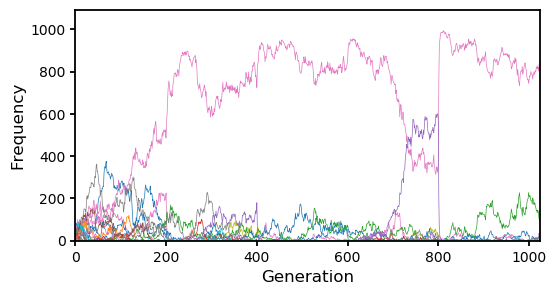

In [12]:
# plot the sequence frequencies as function of time
fig = plotPop(freqs);

In [15]:
# THIS WILL TAKE A WHILE, ~10HOUR ON LAPTOP 

# sweep over different epoch times (with replicates),
# calculating the entropy each time.

numReps = 8
epochTimes = Float64.([0.25,0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]);
entropyData = zeros(numReps, length(epochTimes))
for (i,τ) in enumerate(epochTimes)
    print("working on $i\r")
    # pmap = parallel map, allows you to use many cores at once.
    entropyData[:,i] = pmap(x -> wrapper(L,P,w,K,μ,β,σ,numEnvs,numGens,τ),1:numReps)
end

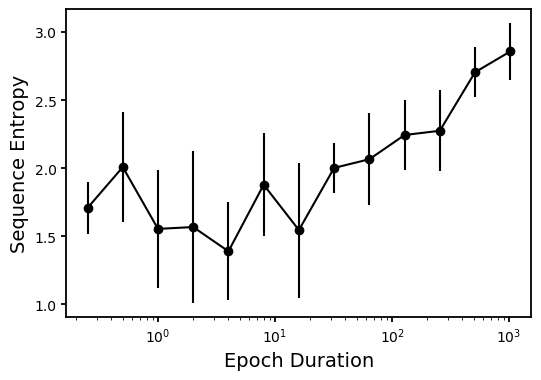

In [16]:
#name = "mu0.001_sub--0_Big"
means = vec(mean(entropyData,dims=1))
errors = 1.96 .* vec(std(entropyData,dims=1)) ./ sqrt(numReps)
fig = plotEntropy(epochTimes, means, errors);
#fig.savefig("sequence_entropy_$name.svg", format="svg", bbox="tight")
#save("entropyData_$name.jld", "1", entropyData)